# Transformer from scratch

- All code in this section are write from scratch (Pytorch Only)

- check `Predict process` in `Train and Predict` for predict result

---

Table of contents:
- Install Library and Data
- Data Preprocessing: such as tokenized, data shuffle and data spliting
- Transformer model:
  - Multi-head Attention and Utils(such as time, try_gpu, plot function)
  - Encoder and Decoder: The network part of the transformer
  - Train and predict
    - Train process
    - Predict process
---
- Data: ```ADME(name = 'HIA_Hou')``` (Classification problem)
- Output:
  ```
Accuracy: 0.5988372093023255
TP,TN,FP,FN: 94 9 9 60
Precision: 0.912621359223301
Recall: 0.6103896103896104
AUC: 0.5551948051948052
  ```

### Install Library and Data

In [58]:
%pip install PyTDC
%pip install PyTDC --upgrade
%pip install matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
!pip install plot-metric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import math
import pandas
import torch
from torch import nn
import time
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
import collections
from IPython import display
from tdc.single_pred import ADME

### Data Preprocessing

In [60]:
def get_vocab(data):
  """ Get the Vocab(unique token) of the whole data set"""
  drug = list(data['Drug'])
  drug = "".join(list(drug)) #join all the drug struecture together
  unique_token = set(drug)
  return unique_token


def encode_drug(input_string, unique_token):
  """ Encode the drug sturcture input (text) into tensor"""
  char_to_int = {char: i for i, char in enumerate(unique_token)}
  token_indices = [char_to_int[char] for char in input_string]
  tokens = torch.tensor(token_indices) # Convert the token indices to a PyTorch tensor
  return tokens

def preprocess_drug(dict_data, num_steps = 50): #change the into word
  vocab = get_vocab(dict_data) #get the unique token of the whole dataset
  res = [encode_drug(i, vocab) for i in list(dict_data['Drug'])]
  Y = torch.tensor(list(dict_data['Y']))
    
  max_length = num_steps
  X_valid_len = torch.zeros(Y.size())
  Y_valid_len = torch.ones(Y.size())
  for i in range(len(res)): #truncation and padding
    a = res[i]
    
    # Check if the tensor is shorter than 50 elements
    if a.size(0) < max_length: #padding
      X_valid_len[i] = a.size(0)
      padding_size = max_length - a.size(0) # Calculate the number of zeros to pad
      res[i] = torch.nn.functional.pad(a, (0, padding_size), 'constant', 0) # Pad the tensor with zeros
    else:# Otherwise, truncation
      res[i] = a[0:max_length]
      X_valid_len[i] = max_length
      
  X = torch.stack(res)
  return X, X_valid_len, Y, Y_valid_len


def load_array(data_arrays, batch_size, is_train=True): #a general data loader
    """Construct a PyTorch data iterator.
    Defined in :numref:`sec_utils`"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)


def read_data_drug():
  data = ADME(name = 'HIA_Hou')
  # split = data.get_split()
  dict_data = data.get_data(format = 'dict') #get the dictionary form of data
  return dict_data

def shuffle_dict(dict_data):
  """ Shuffle the data with seed = 888(random number)"""
  _, Drug, Y = dict_data
  Drug, Y = list(dict_data[Drug]), list(dict_data[Y])
  random.Random(888).shuffle(Drug)
  random.Random(888).shuffle(Y)
  new_dict = {}
  new_dict['Drug'], new_dict['Y'] = Drug, Y
  return new_dict

def split_train_and_test(dict_data, train_rate = 0.7):
  """ Split the dataset into Trainning set and Test set"""
  dict_data = read_data_drug() #origianl data
  dict_data = shuffle_dict(dict_data) #shuffle the data

  n = len(dict_data['Drug'])
  train_rate = 0.7

  dict_data_Drug = dict_data['Drug']
  dict_data_Y = dict_data['Y']
  dict_data_Drug_train = dict_data_Drug[0:round(train_rate*n)]
  dict_data_Drug_test = dict_data_Drug[round(train_rate*n)+1:n]
  dict_data_Y_train = dict_data_Y[0:round(train_rate*n)]
  dict_data_Y_test = dict_data_Y[round(train_rate*n)+1:n]

  train_data = {'Drug': dict_data_Drug_train, 'Y':dict_data_Y_train}
  test_data = {'Drug': dict_data_Drug_test, 'Y':dict_data_Y_test}
  return train_data, test_data
  

  
def load_data_drug(batch_size, num_steps, train_or_test = 'train',problem_type = 'classification'): #data loader for Drug dataset
  dict_data = read_data_drug() #load the data
  train_data, test_data = split_train_and_test(dict_data, train_rate=0.7) #splict the data into train set and test set
  dict_data = train_data if train_or_test == 'train' else test_data

  X, X_valid_len, Y, Y_valid_len = preprocess_drug(dict_data, num_steps = num_steps)

  if problem_type == 'classification':
    y = torch.zeros(Y.size(0), 2)
    y[torch.arange(Y.size(0)), Y] = 1
    Y = y

  data_array = (X, X_valid_len, Y, Y_valid_len)
  data_iter = load_array(data_array, batch_size)
  # return data_iter
  # print("X size: ",X.size())
  # print(dict_data)
  # print("Y size: ",Y.size())
  # print("X valid len size: ",X_valid_len.size())
  # print("Y valid len size: ",Y_valid_len.size())
  return data_iter



# train_loader = load_data_drug(batch_size = 100,num_steps = 50)



In [61]:
# #test the output before and after embedding
# num_hiddens = 32
# num_steps = 5 #每个字向量有多长（维度d）
# vocab_size  = len(vocab) #字典有多少个unique token
# embedding = nn.Embedding(len(vocab), num_hiddens) # nn.Embedding object: input: length of vocab, num_steps

# print("There're ",len(vocab)," unique tokens in the vocabulary")
# print("The dimension of each drug is: ",max_length)

# word = res[0:10,:] #取第1到3行试一试
# print("The size of 3 word: ", word.size())
# embed = embedding(torch.LongTensor(word))
# # print(embed) 
# print("the size of 3 embeded-word: ",embed.size())

## Transformer Model and Train/Predict

### Multi-head Attention and Utils

In [62]:
def sequence_mask(X, valid_len, value=0):
    # print("Here is the size of X in sequence mask: ", X.size())
    maxlen = X.size(1)
    # print("The value of maxlen: ", maxlen)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
  if valid_lens is None: #if valid_lens is none then do standrad softmax
    return nn.functional.softmax(X, dim = -1)
  else:
    shape = X.shape
    if valid_lens.dim() == 1:
      valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else:
      valid_lens = valid_lens.reshape(-1) #reshape to one-dimension

    X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6) 
    return nn.functional.softmax(X.reshape(shape), dim=-1)
  
# masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))
# masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

In [63]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
      weights = torch.ones_like(label) #weight = [1,1...,1]
      weights = sequence_mask(weights, valid_len) #use sequence_mask to generate a 0-1 weight
      self.reduction='none'
      unweighted_loss = super().forward( pred.permute(0, 2, 1), label) #the loss of each time-step and sample(put the predict feature into the second position (Pytorch reqirement))
      weighted_loss = (unweighted_loss * weights).mean(dim=1) # use maen for each sentence
      return weighted_loss

# loss = MaskedSoftmaxCELoss()
# # input size: batch_size = 3, time_step = 4, dimension of each step is 10
# loss(torch.ones(3,4,10), torch.ones((3,4),dtype = torch.long),torch.tensor([4,2,0]))
## output: tensor([2.3026, 1.1513, 0.0000])

In [64]:
#Two ways to calculate the attention weights (Transformer use the second one)

class AdditiveAttention(nn.Module):
  def __init__(self,key_size, query_size, num_hiddens, dropout, **kwargs):
    super(AdditiveAttention, self).__init__(**kwargs)
    self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
    self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
    self.w_v = nn.Linear(num_hiddens, 1, bias=False)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, queries, keys, values, valid_lens): #valid_lens: how many key-value paris is needed
    queries, keys = self.W_q(queries), self.W_k(keys)
    features = queries.unsqueeze(2) + keys.unsqueeze(1) # boradcasting
    features = torch.tanh(features)

    scores = self.w_v(features).squeeze(-1)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values) # batch matrix-matrix product


class DotProductAttention(nn.Module):
  def __init__(self, dropout, **kwarg):
    super(DotProductAttention, self).__init__(**kwarg)
    self.dropout = nn.Dropout(dropout) #need to set the rate of dropout
  
  def forward(self, queries, keys, values, valid_lens = None):
    d = queries.shape[-1]
    scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d) #calculate the attention weight: transpose the key inorder to use torch.bmm
    self.attention_weights = masked_softmax(scores, valid_lens) #calculate the masked_softmax
    return torch.bmm(self.dropout(self.attention_weights), values)


In [65]:
def transpose_qkv(X, num_heads):
  """For Parallel Computing the MultiHeadAttention"""
  # Shape of input X:(batch_size，query_size，  num_hiddens)
  # Shape of output X:(batch_size*num_heads,query_size, num_hiddens/num_heads)

  X = X.reshape(X.shape[0], X.shape[1], num_heads, -1) 
  X = X.permute(0, 2, 1, 3)#(batch_size，num_heads，query_size, num_hiddens/num_heads)
  return X.reshape(-1, X.shape[2], X.shape[3]) # output shape: (batch_size*num_heads,query_size, num_hiddens/num_heads)

def transpose_output(X, num_heads):
  """recover the transpose_qkv"""
  X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
  X = X.permute(0, 2, 1, 3)
  return X.reshape(X.shape[0], X.shape[1], -1)

In [66]:
#The size of output is num_hiddens
class MultiHeadAttention(nn.Module):
  def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
    super(MultiHeadAttention, self).__init__(**kwargs)
    self.num_heads = num_heads
    self.attention = DotProductAttention(dropout)

    self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
    self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
    self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)

    self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

  def forward(self,queries, keys, values, valid_lens): 
    # Notice that we don't use for loop for each head, instead, use a trick: 
    # put the num_head to batch_size during attention process by transpose_qkv 
    # then return the origianl form of X by transpose_output
    queries = transpose_qkv(self.W_q(queries), self.num_heads)
    keys = transpose_qkv(self.W_k(keys), self.num_heads)
    values = transpose_qkv(self.W_v(values), self.num_heads)

    if valid_lens is not None:
      valid_lens = torch.repeat_interleave(
          valid_lens, repeats=self.num_heads, dim=0)
    
    output = self.attention(queries, keys, values, valid_lens)
    output_concat = transpose_output(output, self.num_heads)
    return self.W_o(output_concat)

In [67]:
# Actually it's a MLP
class PositionWiseFFN(nn.Module):
  def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
    super(PositionWiseFFN, self).__init__(**kwargs)
    self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
    self.relu = nn.ReLU()
    self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
  
  def forward(self,X):
    return self.dense2(self.relu(self.dense1(X)))

# ffn = PositionWiseFFN(4,4,8)
# ffn.eval()
# ffn(torch.ones(2,3,4))[0]

In [68]:
# Batch-Norm and Layer-Norm
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
# X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# print('layer norm:', ln(X), '\nbatch norm:', bn(X))

In [69]:
# Dimension of input and output are equal
class AddNorm(nn.Module):
  def __init__(self,normalized_shape, dropout, **kwargs):
    super(AddNorm, self).__init__(**kwargs)
    self.dropout = nn.Dropout(dropout)
    self.ln = nn.LayerNorm(normalized_shape)
  
  def forward(self,X,Y):
    return self.ln(self.dropout(Y) + X)

# add_norm = AddNorm([3, 4], 0.5)
# add_norm.eval()
# add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

In [70]:
class PositionalEncoding(nn.Module):
    """Position encoding"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

#### some genreal function


In [71]:
def cpu():
    """Defined in :numref:`sec_use_gpu`"""
    return torch.device('cpu')

def gpu(i=0):
    """Defined in :numref:`sec_use_gpu`"""
    return torch.device(f'cuda:{i}')


def num_gpus():
    """Defined in :numref:`sec_use_gpu`"""
    return torch.cuda.device_count()


def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu().

    Defined in :numref:`sec_use_gpu`"""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()

def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists.

    Defined in :numref:`sec_use_gpu`"""
    return [gpu(i) for i in range(num_gpus())]


In [72]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`sec_minibatch_sgd`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [73]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_utils`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [74]:
def grad_clipping(net, theta):
    """Clip the gradient.

    Defined in :numref:`sec_utils`"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### Encoder and Decoder

In [75]:
# Basic class of Encoder and Decoder

class Encoder(nn.Module):
  def __init__(self, **kwargs):
    super(Encoder).__init__(**kwargs)
  
  def forward(self, X, *args):
    raise NotImplementedError

class Decoder(nn.Module):
  def __init__(self, **kwargs):
    super(Decoder).__init__(**kwargs)
  
  def init_state(self, enc_output, *args):
    raise NotImplementedError
  def forward(self, X, state):
    raise NotImplementedError

class EncoderDecoder(nn.Module):
  def __init__(self, encoder, decoder, **kwargs):
      super(EncoderDecoder, self).__init__(**kwargs)
      self.encoder = encoder
      self.decoder = decoder

  def forward(self, enc_X, dec_X, *args):
      enc_outputs = self.encoder(enc_X, *args)
      # print("Here is the size of encoder ouput: ", enc_outputs.size())
      dec_state = self.decoder.init_state(enc_outputs, *args) # set the initial_state of decoder as the output of encoder
      # print("Here is the size of Decoder: ", dec_X.size())
      return self.decoder(dec_X, dec_state)

In [76]:
class EncoderBlock(nn.Module):
  def __init__(self, key_size, query_size, value_size, num_hiddens,
               norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
               dropout, use_bias = False, **kwargs):
    super(EncoderBlock,self).__init__(**kwargs)
    self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias)
    self.addnorm1 = AddNorm(norm_shape, dropout)
    self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
    self.addnorm2 = AddNorm(norm_shape, dropout)

  def forward(self,X, valid_lens):
    Y = self.addnorm1(
        X, self.attention(X, X, X, valid_lens)) #use self-attention
    return self.addnorm2(Y, self.ffn(Y))

# X = torch.ones((2, 100, 24))
# valid_lens = torch.tensor([3, 2])
# encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
# encoder_blk.eval()
# encoder_blk(X, valid_lens).shape

In [77]:
class TransformerEncoder(Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
      super().__init__()
      nn.Module.__init__(self)

      self.num_hiddens = num_hiddens
      self.embedding = nn.Embedding(vocab_size, num_hiddens) #embed the input X
      self.pos_encoding = PositionalEncoding(num_hiddens, dropout) #do the position encoding 

      self.blks = nn.Sequential() # for each blk in blks: [index, network]
      for i in range(num_layers): #num_layer: how many encoder block (N)
          self.blks.add_module("block"+str(i),
              EncoderBlock(key_size, query_size, value_size, num_hiddens,
                            norm_shape, ffn_num_input, ffn_num_hiddens,
                            num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
      #pre-process the data
      X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))

      #calculate the attention weight
      self.attention_weights = [None] * len(self.blks)
      for i, blk in enumerate(self.blks):
          X = blk(X, valid_lens)
          self.attention_weights[i] = blk.attention.attention.attention_weights 
      # print("The size of encoder output: ", X.size())
      return X

# encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
# encoder.eval()
# encoder(torch.ones((2, 100), dtype=torch.long), valid_lens = None).shape

In [78]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
      super(DecoderBlock, self).__init__(**kwargs)
      self.i = i
      self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout) #masked-multihead-attention
      self.addnorm1 = AddNorm(norm_shape, dropout)
      self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout) #attention with input from encoder
      self.addnorm2 = AddNorm(norm_shape, dropout)
      self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
      self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state): #input and ouput are the same size
      enc_outputs, enc_valid_lens = state[0], state[1]
    
      if state[2][self.i] is None: #tranning state
          key_values = X
      else: # concate together while prdiction
          key_values = torch.cat((state[2][self.i], X), axis=1)
      state[2][self.i] = key_values

      if self.training: 
          batch_size, num_steps, _ = X.shape
          dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
      else:
          dec_valid_lens = None

      # attention 1(masked)
      X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
      Y = self.addnorm1(X, X2)

      # attention2
      Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
      Z = self.addnorm2(Y, Y2)
      return self.addnorm3(Z, self.ffn(Z)), state 



# decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
# decoder_blk.eval()
# enc_output = encoder(torch.ones((2, 100), dtype=torch.long), valid_lens = None)
# state = [enc_output, valid_lens, [None]]
# X = torch.ones((2, 100, 24))
# decoder_blk(X, state)[0].size()

# ouput: torch.Size([2, 100, 24])

In [79]:
class AttentionDecoder(Decoder):
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    @property
    def attention_weights(self):
        raise NotImplementedError

class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
      super(TransformerDecoder, self).__init__(**kwargs)
      nn.Module.__init__(self)

      self.num_hiddens = num_hiddens
      self.num_layers = num_layers
      self.embedding = nn.Embedding(vocab_size, num_hiddens)
      self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
      self.blks = nn.Sequential()
      for i in range(num_layers):
          self.blks.add_module("block"+str(i),
              DecoderBlock(key_size, query_size, value_size, num_hiddens,
                            norm_shape, ffn_num_input, ffn_num_hiddens,
                            num_heads, dropout, i))
      self.dense_1 = nn.Linear(num_hiddens, 2) #ouput layer is 2
      self.dense_2 = nn.Linear(2 * num_steps,2)

    def init_state(self, enc_outputs, enc_valid_lens, *args): #for prediction
      return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state): 
      X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))

      self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
      for i, blk in enumerate(self.blks):
          X, state = blk(X, state)
          # weight of attention1
          self._attention_weights[0][i] = blk.attention1.attention.attention_weights
          # weight of attention2
          self._attention_weights[1][i] = blk.attention2.attention.attention_weights
      
      X = self.dense_1(X)
      batch_size = X.size(0)
      X = self.dense_2(X.reshape(batch_size,-1))

      # print("The shape of the decoder output: ",X.size())
      # print("A example of the decoder output: ",X[0])
      # while True:
      #   raise Exception("debug")

      return torch.sigmoid(X), state 

    @property
    def attention_weights(self):
        return self._attention_weights



### Train and predict

#### Training process

In [80]:
def train_seq2seq(net, data_iter, lr, num_epochs, device): 
  def xavier_init_weights(m): #weight initialized method
      if type(m) == nn.Linear:
          nn.init.xavier_uniform_(m.weight)
      if type(m) == nn.GRU:
          for param in m._flat_weights_names:
              if "weight" in param:
                  nn.init.xavier_uniform_(m._parameters[param])

  net.apply(xavier_init_weights)
  net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  # loss = torch.nn.BCEWithLogitsLoss()
  loss = torch.nn.BCELoss() #since the output of decoder is end with a sigmoid, so we don't use torch.nn.BCEWithLogitsLoss()
  net.train()

  animator = Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs]) 

  for epoch in range(num_epochs):
    timer = Timer()
    metric = Accumulator(2)  
    for batch in data_iter:
      optimizer.zero_grad() #clear gradient of batch
      X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch] 
      dec_input = X 
      Y_hat, _ = net(X, dec_input, X_valid_len) 
      # print("size of Y: ",type(Y), "  size of Y_hat: ", type(Y_hat))

      Y_hat = torch.sigmoid(Y_hat)
      Y = torch.sigmoid(Y)
      l = loss(Y_hat, Y) #loss function
      print("loss value: ",l.sum())
      
      l.sum().backward()      
      grad_clipping(net, 1) 
      num_tokens = Y_valid_len.sum() 
      optimizer.step() 
      with torch.no_grad():
          metric.add(l.sum(), num_tokens)

    if (epoch + 1) % 5 == 0:
        animator.add(epoch + 1, (metric[0] / metric[1],))
  print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} ' f'tokens/sec on {str(device)}')


loss 0.020, 534.9 tokens/sec on cuda:0


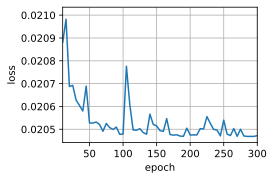

In [81]:
# Hyper-parameters
num_hiddens, num_layers, dropout, batch_size, num_steps = 64, 3, 0.1, 32, 128
lr, num_epochs, device = 0.001, 300, try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 64, 128, 4
key_size, query_size, value_size = 64,64,64
norm_shape = [64]

# train_iter = load_data_drug(batch_size = batch_size,num_steps = num_steps)
train_iter = load_data_drug(batch_size = batch_size, num_steps = num_steps, train_or_test='train',problem_type='classification')

# Encoder and Decoder
encoder = TransformerEncoder(
    num_steps, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

decoder = TransformerDecoder(
    num_steps, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

net = EncoderDecoder(encoder, decoder)

train_seq2seq(net, train_iter, lr, num_epochs, device)

#### Predict process

In [82]:
def predict_seq2seq(net,data_iter,num_steps,device):
  net.eval()
  output = []
  test_Y = []
  for batch in data_iter:
    X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch] 
    X = X.to(device)
    dec_input = X 
    Y_hat, _ = net(X, dec_input, X_valid_len) # Get the predict value Y_hat
    output.append(Y_hat)
    test_Y.append(Y)
  pred = torch.cat(output,dim = 0)
  return pred, torch.cat(test_Y,dim = 0)


In [83]:
test_iter = load_data_drug(batch_size = batch_size, num_steps = num_steps, train_or_test='test',problem_type='classification') #load the test data with data loader
pred, Y = predict_seq2seq(net,test_iter,40,device)

print("Size of pred: ", pred.size())
binary_pred = torch.argmax(pred, dim = 1)
Y = torch.argmax(Y, dim = 1)
print("Predict Label:",binary_pred)
print("True Label",Y)

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


Size of pred:  torch.Size([172, 2])
Predict Label: tensor([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0], device='cuda:0')
True Label tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 

In [84]:
from sklearn import metrics
import pandas as pd

In [85]:
y = np.array(Y.cpu().detach())
y_hat = np.array(binary_pred.cpu().detach())
print("Accuracy:", np.sum(y == y_hat)/len(y))

fpr, tpr, thresholds = metrics.roc_curve(y,y_hat, pos_label=1)

df = {'y':y, 'y_hat':y_hat}
df = pd.DataFrame(df)
TP = sum(((df['y'] == 1) & (df['y_hat'] ==1)))
TN = sum(((df['y'] == 0) & (df['y_hat'] ==0)))
FP = sum(((df['y'] == 0) & (df['y_hat'] ==1)))
FN = sum(((df['y'] == 1) & (df['y_hat'] ==0)))
print("TP,TN,FP,FN:",TP,TN,FP,FN)

print("Precision:", TP/(TP+FP))
print("Recall:", TP/(TP+FN))
print("AUC:",metrics.auc(fpr, tpr))

from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y, y_hat, labels=["Class 1", "Class 2"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()


Accuracy: 0.5988372093023255
TP,TN,FP,FN: 94 9 9 60
Precision: 0.912621359223301
Recall: 0.6103896103896104
AUC: 0.5551948051948052


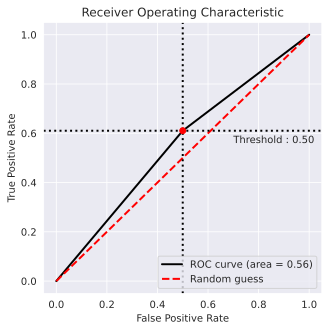

In [87]:
from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y, y_hat, labels=["Class 1", "Class 2"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

# Use API: Deep Purpose

In [ ]:
# %pip install git+https://github.com/bp-kelley/descriptastorus 
# %pip install DeepPurpose
# %pip install PyTDC --upgrade
from DeepPurpose import utils, CompoundPred
from tdc.single_pred import ADME

In [ ]:
ADME(name = 'HIA_Hou').get_data().head(2) #show the raw data

Found local copy...
Loading...
Done!


,Drug_ID,Drug,Y
0,Acetanilide,CC(=O)Nc1ccccc1,1
1,Acetazolamide.mol,CC(=O)Nc1nnc(S(N)(=O)=O)s1,1


In [ ]:
data = ADME(name = 'HIA_Hou').get_data(format = 'dict')
X, y = data['Drug'], data['Y']

Found local copy...
Loading...
Done!


In [ ]:
drug_encoding = 'Transformer' #Model name
train, val, test = utils.data_process( X_drug = X, 
                      y = y, 
                      drug_encoding = drug_encoding,
                      random_seed = 'TDC')

# The function `data process` call the function `encode drug`

Drug Property Prediction Mode...
in total: 578 drugs
encoding drug...
unique drugs: 578
Done.


In [ ]:
train.head(10)

,SMILES,Label,drug_encoding
0,CC(=O)Nc1ccccc1,1,"([184, 201, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,CC(=O)Nc1nnc(S(N)(=O)=O)s1,1,"([184, 1000, 22, 763, 1049, 640, 0, 0, 0, 0, 0..."
2,C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]2CC[C@H]3[C@@H...,1,"([43, 955, 315, 150, 142, 643, 103, 1013, 525,..."
3,Cc1c(N(C)C)c(=N)n(-c2ccccc2)n1C,1,"([218, 343, 107, 71, 236, 567, 35, 265, 804, 0..."
4,COc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2...,1,"([271, 94, 452, 367, 1339, 1133, 458, 697, 579..."
5,CN1CCN(CCCCN2C(=O)CN(/N=C/c3ccc(-c4ccc(Cl)cc4)...,1,"([828, 94, 874, 668, 53, 221, 53, 194, 35, 253..."
6,NS(=O)(=O)c1cc2c(cc1C(F)(F)F)N[C@H](Cc1ccccc1)...,1,"([286, 500, 84, 123, 2141, 19, 1397, 19, 1704,..."
7,CC(=O)Nc1ccc(OC(=O)c2ccccc2OC(C)=O)cc1,1,"([184, 95, 115, 224, 89, 72, 124, 123, 0, 0, 0..."
8,CC(C)COC[C@@H](CN1CCCC1)N(Cc1ccccc1)c1ccccc1,1,"([344, 89, 144, 2537, 106, 199, 295, 201, 0, 0..."
9,O[C@](CCN1CCCCC1)(c1ccccc1)[C@@H]1C[C@H]2C=C[C...,1,"([54, 147, 80, 272, 167, 106, 32, 295, 462, 52..."


In [ ]:
train.head(100)['drug_encoding'][20] # show the date after encoding: encode to 2 * 50 (d = 50)

(array([ 286,  500,   84,  123,  140,  183,  133, 2537, 1187, 1704, 1664,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]))

In [ ]:
train.head(2)['drug_encoding'][]

(array([184, 201,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]))

In [ ]:

config = utils.generate_config(drug_encoding = drug_encoding, 
                         train_epoch = 3, 
                         LR = 0.001, 
                         batch_size = 128,
                          transformer_emb_size_drug = 128,
                          transformer_intermediate_size_drug = 512,
                          transformer_num_attention_heads_drug = 8,
                          transformer_n_layer_drug = 8,
                          transformer_emb_size_target = 64,
                          transformer_intermediate_size_target = 256,
                          transformer_num_attention_heads_target = 4,
                          transformer_n_layer_target = 2,
                          transformer_dropout_rate = 0.1,
                          transformer_attention_probs_dropout = 0.1,
                          transformer_hidden_dropout_rate = 0.1
                        )

In [ ]:
model = CompoundPred.model_initialize(**config)

Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.70030. Total time 0.00055 hours
Validation at Epoch 1 , AUROC: 0.50980 , AUPRC: 0.88582 , F1: 0.93577
Training at Epoch 2 iteration 0 with loss 0.42923. Total time 0.00361 hours
Validation at Epoch 2 , AUROC: 0.40896 , AUPRC: 0.83763 , F1: 0.93577
Training at Epoch 3 iteration 0 with loss 0.39588. Total time 0.00638 hours
Validation at Epoch 3 , AUROC: 0.31372 , AUPRC: 0.81724 , F1: 0.93577
--- Go for Testing ---
Testing AUROC: 0.6396039603960397 , AUPRC: 0.9064528597024841 , F1: 0.9308755760368664
--- Training Finished ---


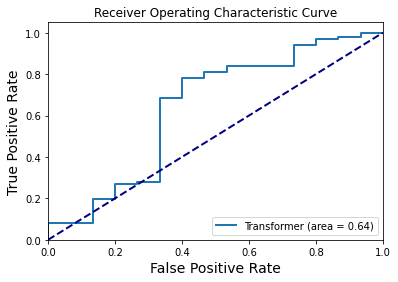

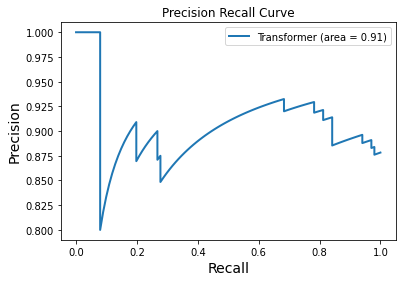

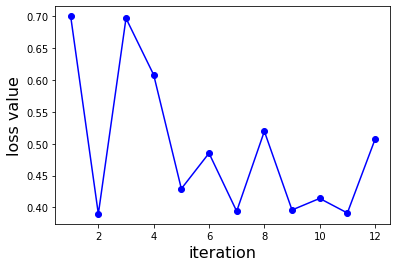

In [ ]:
# Training
model.train(train, val, test)

In [ ]:
model.save_model('./tutorial_model')